While analyzing ELF binaries such as `readelf` and `bash` provides a baseline for understanding and verifying output produced by Centrifuge, these files do not present realistic use cases. One of Centrifuge's design goals was to assist with firmware analysis, complementing existing tools such as the tried and true `binwalk`. Firmware analysis presents a special set of challenges to reverse engineering, such as not having a standard format analogous to ELF or PE files, no metadata describing file layout or target CPU, frequently being compressed or encrypted, and so on. Often many files are bundled together in a single binary image and it is not clear where the machine code is, or if there is any machine code present to begin with. Centrifuge can help overcome these challenges, as will be demonstrated here.

<h1>Draytek VigorSwitch P2261</h1>

The firmware for this device can be downloaded here:

https://www.draytek.com.tw/ftp/VigorSwitch%20P2261/Firmware/v3.48/VigorSwitch-P2261_v3.48.zip


Unzipping this produces a file called `P2261_v3.48.dat`. This can be unpacked with `binwalk`.

```
$ binwalk -e P2261_v3.48.dat 

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
8             0x8             gzip compressed data, has original file name: "P2261_v3.48.bin", from Unix, last modified: 2017-11-08 02:33:25
3690683       0x3850BB        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3693095       0x385A27        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3694815       0x3860DF        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3723160       0x38CF98        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3752241       0x394131        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3754289       0x394931        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3755525       0x394E05        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3796954       0x39EFDA        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
3798670       0x39F68E        gzip compressed data, last modified: 1970-01-01 00:00:00 (null date)
```

A signature scan of the `P2261_v3.48.bin` file finds some interesting matches:

```
$ binwalk P2261_v3.48.bin 

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
0             0x0             eCos kernel exception handler, architecture: MIPSEL, exception vector table base address: 0x80000200
128           0x80            eCos kernel exception handler, architecture: MIPSEL, exception vector table base address: 0x80000200
5040296       0x4CE8A8        Unix path: /home/miranda/GS-23XX-AP4/t/build/obj/ecos/install/include/cyg/libc/stdlib/atox.inl
5040334       0x4CE8CE        eCos RTOS string reference: "ecos/install/include/cyg/libc/stdlib/atox.inl"
5078988       0x4D7FCC        Unix path: /usr/bin/default d %d
5164290       0x4ECD02        eCos RTOS string reference: "ecos/install/include/cyg/libc/time/time.inl"
5197421       0x4F4E6D        Neighborly text, "neighbor_cache_show"
5197449       0x4F4E89        Neighborly text, "neighbor_cache_cleartransition"
...
<output cropped>
```

Not shown in the output above are 470 hits for gzip compressed data:

```
$ binwalk P2261_v3.48.bin | grep gzip | cat -n | tail
   461	7483204       0x722F44        gzip compressed data, last modified: 1970-01-01 00:00:00 
   462	7484920       0x7235F8        gzip compressed data, last modified: 1970-01-01 00:00:00 
   463	7503376       0x727E10        gzip compressed data, last modified: 1970-01-01 00:00:00 
   464	7505260       0x72856C        gzip compressed data, last modified: 1970-01-01 00:00:00 
   465	7506576       0x728A90        gzip compressed data, last modified: 1970-01-01 00:00:00 
   466	7508008       0x729028        gzip compressed data, last modified: 1970-01-01 00:00:00 
   467	7509496       0x7295F8        gzip compressed data, last modified: 1970-01-01 00:00:00 
   468	7770720       0x769260        gzip compressed data, last modified: 1970-01-01 00:00:00 
   469	7771708       0x76963C        gzip compressed data, last modified: 1970-01-01 00:00:00 
   470	7772992       0x769B40        gzip compressed data, last modified: 1970-01-01 00:00:00 
```

This seems like an implausibly high number. It is possible many of these (perhaps all) are false positives. 

Signature scanning is very fast, but has certain drawbacks as we can see here. The hits for MIPSEL eCos kernel exception handlers in the output above may also be false positives. It is necessary to verify whether this file contains any code, and if so which CPU it targets. Any compressed or encrypted data should also be identified.

Now that the firmware is unpacked, Centrifuge can be used to analyze the file.

In [1]:
import sys
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]  

sys.path[0:0] = ['.', '..']

from centrifuge.binfile import BinFile

In [2]:
file_handle = open("_P2261_v3.48.dat.extracted/P2261_v3.48.bin", "rb")
draytek = BinFile(file_handle)
draytek.slice_file()

Like Binwalk, Centrifuge can be used to plot file entropy:

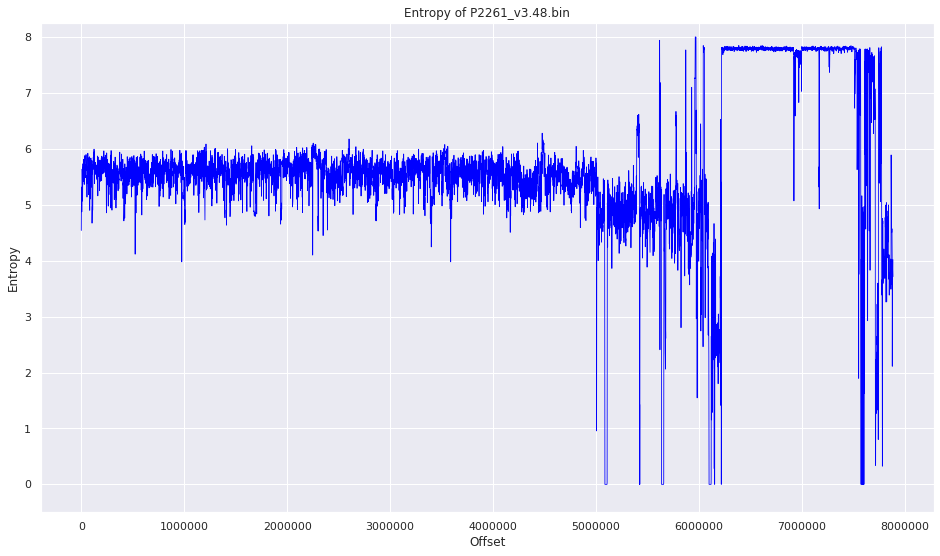

In [3]:
draytek.plot_file_entropy()

High-entropy data is immediately apparent.

A plot of the medians reveals at least 3 distinct types of information:

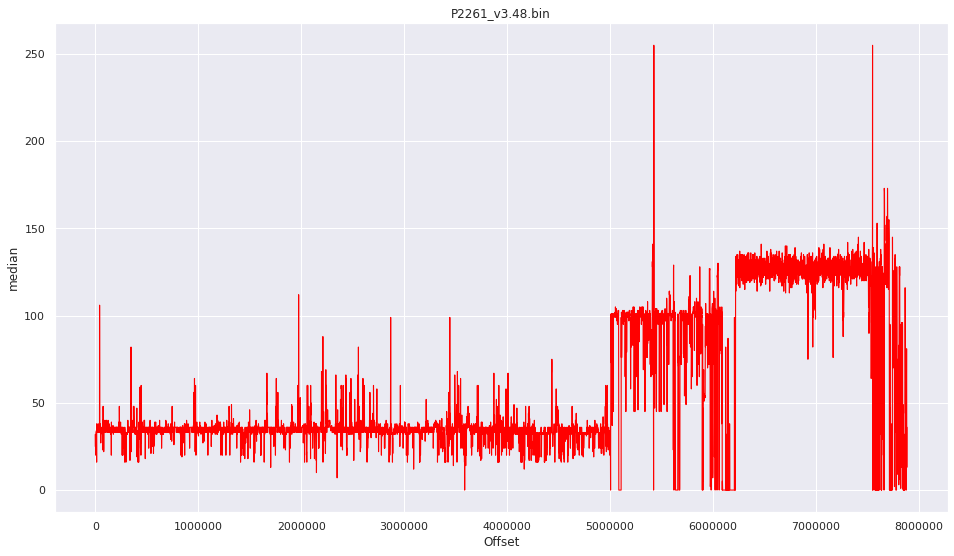

In [4]:
draytek.plot_file_feature("median", "red")

DBSCAN identifies 3 clusters in the file data:

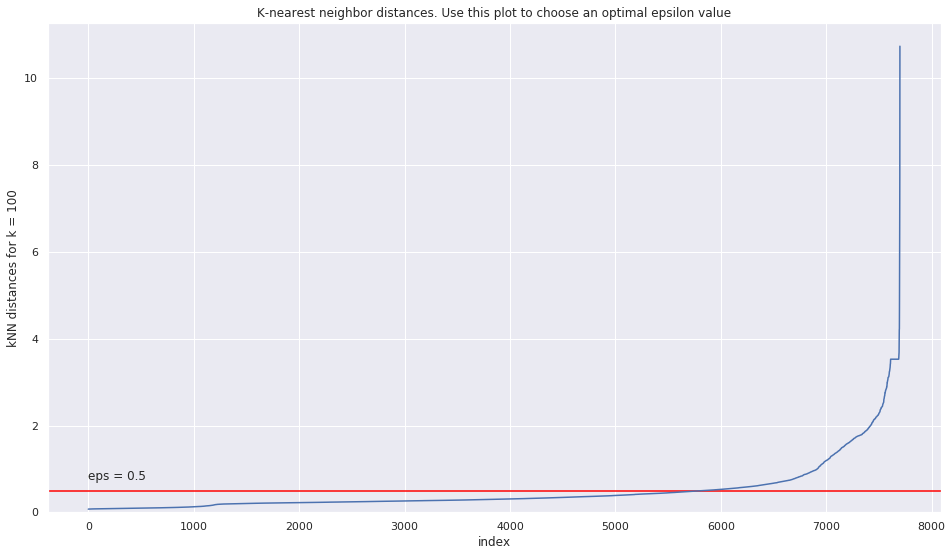

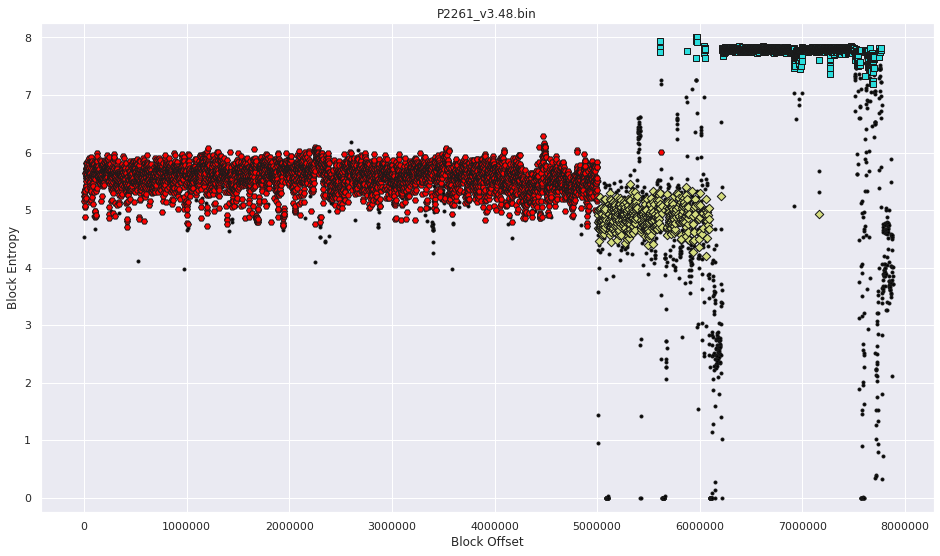

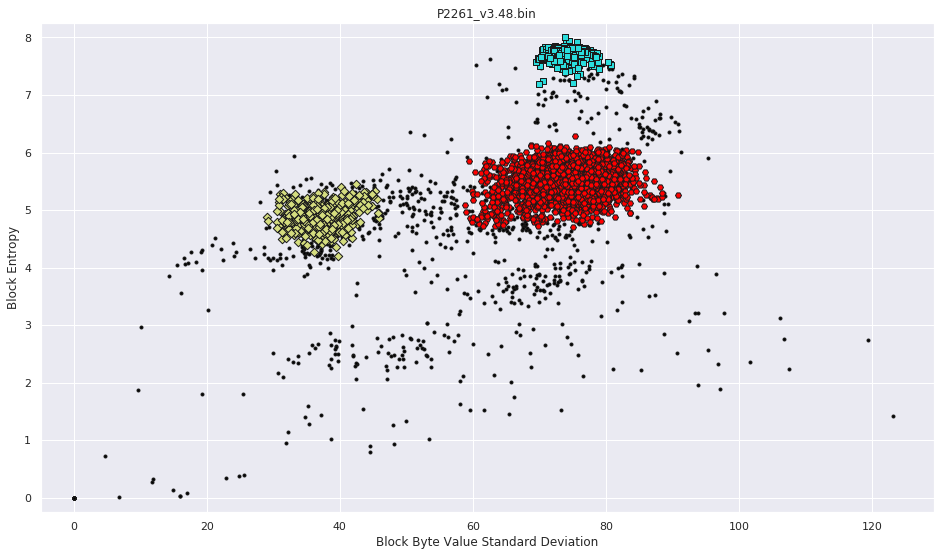

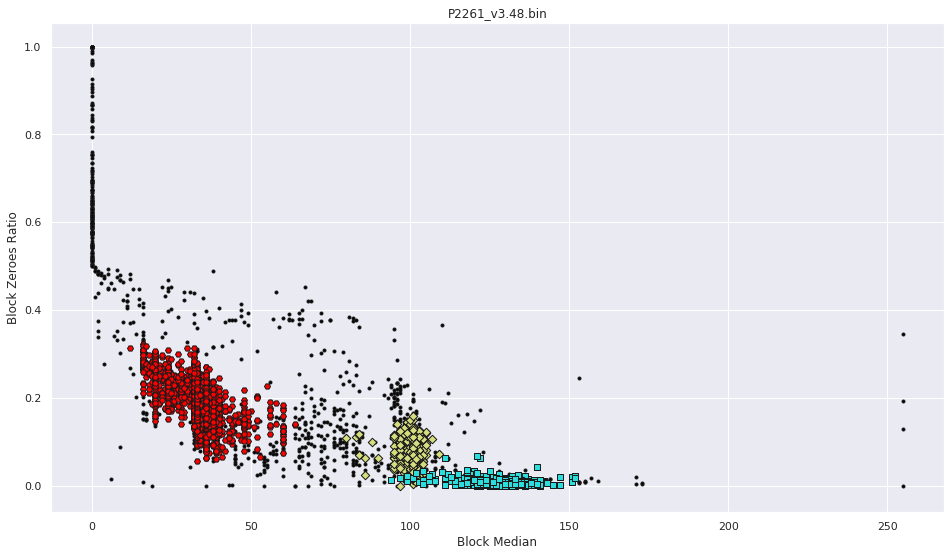

In [6]:
draytek.cluster_DBSCAN(epsilon=0.5,
                       minimum_samples=100,
                       find_optimal_epsilon=True)

draytek.plot_DBSCAN_results()

Finally, Centrifuge can be used to identify what type of data these 3 clusters hold:

In [8]:
results = draytek.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 0 for possible match
[+] Closely matching CPU architecture reference(s) found for Cluster 0
[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "mips",
        "endianness": "little",
        "wordsize": 32
    },
    "prediction_probability": 0.93
}


Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 1
    Wasserstein distance to reference: 7.861589780632858


Searching for high entropy data
-------------------------------------------------------------------

[+] High entropy data found in Cluster 2
    Wasserstein distance to reference: 0.4625352842771307
[*] This distance suggests the data in this cluster is either
    a) encrypted
    b) compressed via LZMA with maximum compression level.



Summing up some of the output above:

 - ISAdetect indicates the code is MIPSEL with a high measure of confidence
 - the distribution of high-entropy data is so close to random that encryption is more likely than gzip compression
 
Regarding the data identified as UTF-8 english, this can easily be confirmed by dumping the cluster byte values and converting them back to binary:

In [9]:
_, cluster_byte_values = draytek.extract_clusters()

bytes(cluster_byte_values[1])[500:1500]

b"--------------------------\x00\x00\nHTTP     Receive: %10ld    Allow: %10ld    Discard: %10ld\x00\x00\nHTTPS    Receive: %10ld    Allow: %10ld    Discard: %10ld\x00\x00\nSNMP     Receive: %10ld    Allow: %10ld    Discard: %10ld\x00\x00\nTELNET   Receive: %10ld    Allow: %10ld    Discard: %10ld\x00\x00\nSSH      Receive: %10ld    Allow: %10ld    Discard: %10ld\n\x00Non-existing entry ID %ld\n\x00\x00W: WEB/HTTPS\n\x00\x00\x00S: SNMP\n\x00\x00\x00\x00T: TELNET/SSH\n\n\x00Idx Start IP Address                End IP Address                 W \x00\x00\x00S \x00\x00--- ------------------------------- ------------------------------ - \x00\x00\x00%-3d \x00\x00\x00%-31s %-30s \x00\x00\x00\x00Parameter <ip_addr> doesn't allowed all zero or all 'ff'H\n\x00\x00Parameter <end_ip_addr> is less than <start_ip_addr>\n\x00\x00\x00Parameter <end_ipv6_addr> is less than <start_ipv6_addr>\n\x00\x00\x00The entry content is duplicated of entry ID %d\n\x00System Access Mode : %s\n\x00\x00\x00\x00Access Mgmt

The full results are printed below. The numbers with many decimal points are Wasserstein distances between the cluster distribution and a reference distribution.

In [10]:
results

{'machine code': [{'Cluster 0': [32.49862732711046,
    {'MIPS64EL_reference': 19.924232948965848,
     'PowerPC_reference': 20.883659907702718,
     'i386_reference': 43.80582976227183,
     'ARMEL_reference': 49.61647526227182,
     'MIPSEL_reference': 8.725178035307984,
     'PPC64_reference': 34.665126421815295,
     'AMD64_reference': 39.868473762271805,
     'ARM64_reference': 38.6632212622718,
     'SH4_reference': 37.33973526227182}],
   'Cluster 1': 48.399124414511334,
   'Cluster 2': 29.187064378404575},
  {'prediction': {'wordsize': 32,
    'endianness': 'little',
    'architecture': 'mips'},
   'prediction_probability': 0.93}],
 'utf8_en': {'Cluster 0': 51.044843164601474,
  'Cluster 1': 7.861589780632858,
  'Cluster 2': 45.58324126570465},
 'high entropy': {'Cluster 0': 61.62208764892008,
  'Cluster 1': 43.96857914890036,
  'Cluster 2': 0.4625352842771307}}